In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import pandas as pd
import json
from urllib.parse import urlparse, parse_qs
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# -------------------- Tokenization and Vocabulary --------------------
def tokenize_url(url):
    parsed = urlparse(url)
    tokens = []
    if parsed.scheme:
        tokens.append(parsed.scheme)
    if parsed.hostname:
        tokens += parsed.hostname.split('.')
    if parsed.path:
        tokens += parsed.path.strip("/").split("/")
    if parsed.query:
        tokens += list(parse_qs(parsed.query).keys())
    return tokens

def build_vocab(df, max_vocab_size=5000):
    token_counts = Counter()
    for url in df['text']:
        tokens = tokenize_url(url)
        token_counts.update(tokens)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for i, (token, _) in enumerate(token_counts.most_common(max_vocab_size), start=2):
        vocab[token] = i
    return vocab

In [3]:
# -------------------- URL to Graph Conversion --------------------
def url_to_graph(url, label, vocab, max_nodes=30):
    tokens = tokenize_url(url)[:max_nodes]
    node_ids = [vocab.get(tok, vocab['<UNK>']) for tok in tokens]
    num_nodes = len(node_ids)
    if num_nodes < 2:
        return None
    edge_index = torch.tensor([[i, i + 1] for i in range(num_nodes - 1)], dtype=torch.long).t()
    x = torch.tensor(node_ids, dtype=torch.long).unsqueeze(1)
    return Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.float))
# -------------------- PyG Dataset --------------------
class URLGraphDataset(InMemoryDataset):
    def __init__(self, df, vocab):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        super().__init__('.')
        data_list = [url_to_graph(url, label, vocab) for url, label in zip(df['text'], df['label']) if url_to_graph(url, label, vocab)]
        self.data, self.slices = self.collate(data_list)

In [4]:
# -------------------- GCN Model --------------------
class URLGNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = GCNConv(embed_dim, 128)
        self.conv2 = GCNConv(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64, 1)

    def forward(self, data):
        x = self.embedding(data.x.squeeze(1))
        x = torch.relu(self.conv1(x, data.edge_index))
        x = torch.relu(self.conv2(x, data.edge_index))
        x = global_mean_pool(x, data.batch)
        x = self.dropout(x)
        return torch.sigmoid(self.fc(x)).squeeze()


In [5]:
# -------------------- Train Function with TQDM + EarlyStopping --------------------
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=None, epochs=30, patience=5):
    best_model_wts = model.state_dict()
    best_val_f1 = 0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_preds': [], 'val_probs': [], 'val_labels': []}

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            preds = (out > 0.5).int()
            correct += (preds == batch.y.int()).sum().item()
            total += batch.num_graphs
        train_loss = total_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_preds, val_probs, val_labels = 0, [], [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                batch = batch.to(device)
                out = model(batch)
                loss = criterion(out, batch.y)
                val_loss += loss.item() * batch.num_graphs
                probs = out.cpu().numpy().tolist()
                preds = (out > 0.5).int().cpu().numpy().tolist()
                labels = batch.y.int().cpu().numpy().tolist()
                val_probs += probs
                val_preds += preds
                val_labels += labels
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_preds'] = val_preds
        history['val_probs'] = val_probs
        history['val_labels'] = val_labels

        print(f"\nEpoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if scheduler:
            scheduler.step(val_f1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = model.state_dict()
            patience_counter = 0
            torch.save(model.state_dict(), "best_gnn_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\n⛔ Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    return model, history


In [6]:
# -------------------- Plotting Functions --------------------
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phish'], yticklabels=['Legit', 'Phish'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

Training samples: 668557, Validation samples: 167140
Vocabulary size: 5002


Epoch 1 [Val]: 100%|██████████| 2133/2133 [01:17<00:00, 27.57it/s]



Epoch 1: Train Loss=0.2265, Acc=0.9038 | Val Loss=0.1888, Acc=0.9197, F1=0.8958


Epoch 2 [Val]: 100%|██████████| 2133/2133 [00:31<00:00, 68.26it/s]



Epoch 2: Train Loss=0.1818, Acc=0.9249 | Val Loss=0.1768, Acc=0.9285, F1=0.9094


Epoch 3 [Val]: 100%|██████████| 2133/2133 [00:32<00:00, 65.38it/s]



Epoch 3: Train Loss=0.1744, Acc=0.9281 | Val Loss=0.1719, Acc=0.9295, F1=0.9106


Epoch 4 [Val]: 100%|██████████| 2133/2133 [00:33<00:00, 64.64it/s]



Epoch 4: Train Loss=0.1697, Acc=0.9298 | Val Loss=0.1707, Acc=0.9295, F1=0.9098


Epoch 5 [Val]: 100%|██████████| 2133/2133 [00:34<00:00, 61.42it/s]



Epoch 5: Train Loss=0.1668, Acc=0.9308 | Val Loss=0.1684, Acc=0.9309, F1=0.9122


Epoch 6 [Val]: 100%|██████████| 2133/2133 [00:36<00:00, 59.23it/s]



Epoch 6: Train Loss=0.1641, Acc=0.9317 | Val Loss=0.1705, Acc=0.9312, F1=0.9125


Epoch 7 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 60.13it/s]



Epoch 7: Train Loss=0.1625, Acc=0.9326 | Val Loss=0.1682, Acc=0.9314, F1=0.9128


Epoch 8 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 60.52it/s]



Epoch 8: Train Loss=0.1611, Acc=0.9333 | Val Loss=0.1680, Acc=0.9316, F1=0.9131


Epoch 9 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 59.52it/s]



Epoch 9: Train Loss=0.1593, Acc=0.9338 | Val Loss=0.1718, Acc=0.9318, F1=0.9133


Epoch 10 [Val]: 100%|██████████| 2133/2133 [00:36<00:00, 59.02it/s]



Epoch 10: Train Loss=0.1589, Acc=0.9343 | Val Loss=0.1729, Acc=0.9324, F1=0.9146


Epoch 11 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 59.70it/s]



Epoch 11: Train Loss=0.1578, Acc=0.9347 | Val Loss=0.1732, Acc=0.9326, F1=0.9146


Epoch 12 [Val]: 100%|██████████| 2133/2133 [00:34<00:00, 62.26it/s]



Epoch 12: Train Loss=0.1569, Acc=0.9351 | Val Loss=0.1711, Acc=0.9327, F1=0.9146


Epoch 13 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 59.86it/s]



Epoch 13: Train Loss=0.1557, Acc=0.9353 | Val Loss=0.1724, Acc=0.9327, F1=0.9149


Epoch 14 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 59.46it/s]



Epoch 14: Train Loss=0.1553, Acc=0.9355 | Val Loss=0.1706, Acc=0.9328, F1=0.9146


Epoch 15 [Val]: 100%|██████████| 2133/2133 [00:36<00:00, 57.68it/s]



Epoch 15: Train Loss=0.1544, Acc=0.9358 | Val Loss=0.1719, Acc=0.9325, F1=0.9143


Epoch 16 [Val]: 100%|██████████| 2133/2133 [00:36<00:00, 59.18it/s]



Epoch 16: Train Loss=0.1541, Acc=0.9360 | Val Loss=0.1709, Acc=0.9335, F1=0.9157


Epoch 17 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 59.97it/s]



Epoch 17: Train Loss=0.1534, Acc=0.9361 | Val Loss=0.1725, Acc=0.9333, F1=0.9154


Epoch 18 [Val]: 100%|██████████| 2133/2133 [00:36<00:00, 59.24it/s]



Epoch 18: Train Loss=0.1529, Acc=0.9365 | Val Loss=0.1764, Acc=0.9326, F1=0.9140


Epoch 19 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 59.93it/s]



Epoch 19: Train Loss=0.1525, Acc=0.9365 | Val Loss=0.1760, Acc=0.9325, F1=0.9137


Epoch 20 [Val]: 100%|██████████| 2133/2133 [00:37<00:00, 56.98it/s]



Epoch 20: Train Loss=0.1504, Acc=0.9374 | Val Loss=0.1743, Acc=0.9333, F1=0.9155


Epoch 21 [Val]: 100%|██████████| 2133/2133 [00:40<00:00, 52.14it/s]



Epoch 21: Train Loss=0.1496, Acc=0.9374 | Val Loss=0.1767, Acc=0.9336, F1=0.9159


Epoch 22 [Val]: 100%|██████████| 2133/2133 [00:37<00:00, 57.28it/s]



Epoch 22: Train Loss=0.1495, Acc=0.9377 | Val Loss=0.1754, Acc=0.9332, F1=0.9151


Epoch 23 [Val]: 100%|██████████| 2133/2133 [00:37<00:00, 56.84it/s]



Epoch 23: Train Loss=0.1490, Acc=0.9378 | Val Loss=0.1758, Acc=0.9337, F1=0.9158


Epoch 24 [Val]: 100%|██████████| 2133/2133 [00:37<00:00, 56.89it/s]



Epoch 24: Train Loss=0.1484, Acc=0.9378 | Val Loss=0.1777, Acc=0.9333, F1=0.9152


Epoch 25 [Val]: 100%|██████████| 2133/2133 [00:37<00:00, 57.16it/s]



Epoch 25: Train Loss=0.1472, Acc=0.9381 | Val Loss=0.1756, Acc=0.9336, F1=0.9157


Epoch 26 [Val]: 100%|██████████| 2133/2133 [00:35<00:00, 60.66it/s]



Epoch 26: Train Loss=0.1468, Acc=0.9383 | Val Loss=0.1784, Acc=0.9338, F1=0.9160


Epoch 27 [Val]: 100%|██████████| 2133/2133 [00:41<00:00, 51.23it/s]



Epoch 27: Train Loss=0.1465, Acc=0.9384 | Val Loss=0.1807, Acc=0.9338, F1=0.9161


Epoch 28 [Val]: 100%|██████████| 2133/2133 [00:40<00:00, 52.13it/s]



Epoch 28: Train Loss=0.1468, Acc=0.9384 | Val Loss=0.1808, Acc=0.9339, F1=0.9162


Epoch 29 [Val]: 100%|██████████| 2133/2133 [00:41<00:00, 51.03it/s]



Epoch 29: Train Loss=0.1465, Acc=0.9384 | Val Loss=0.1798, Acc=0.9337, F1=0.9160


Epoch 30 [Val]: 100%|██████████| 2133/2133 [00:39<00:00, 53.71it/s]



Epoch 30: Train Loss=0.1462, Acc=0.9384 | Val Loss=0.1841, Acc=0.9338, F1=0.9162


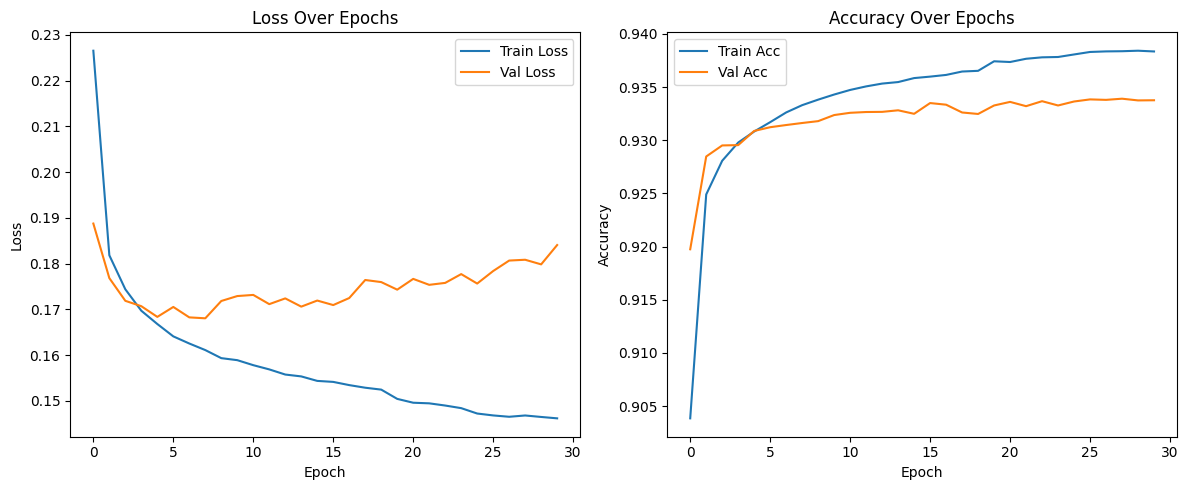

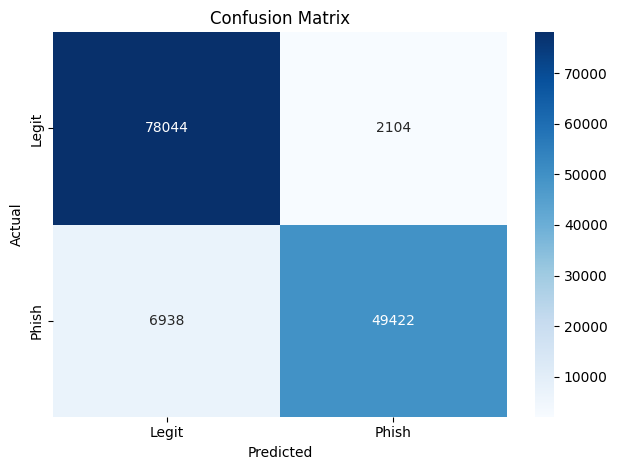

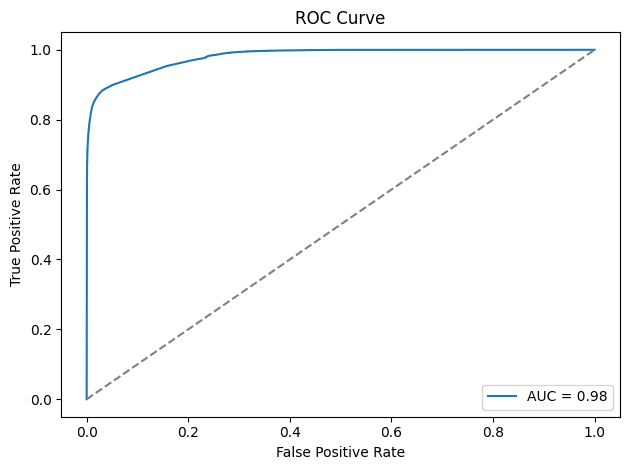

In [9]:
from sklearn.model_selection import train_test_split
# -------------------- Main Pipeline --------------------
 # columns: URL, label
df = pd.read_json(r"E:\Phising_detection\dataset\urls\urls.json")

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
vocab = build_vocab(train_df)
print(f"Vocabulary size: {len(vocab)}")
train_data = URLGraphDataset(train_df, vocab)
val_data = URLGraphDataset(val_df, vocab)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = URLGNN(vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
criterion = nn.BCELoss()

model, history = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=scheduler, epochs=30, patience=5)

plot_metrics(history)
plot_confusion_matrix(history['val_labels'], history['val_preds'])
plot_roc_curve(history['val_labels'], history['val_probs'])

torch.save(model.state_dict(), "best_gnn_model.pt")
with open("vocab.json", "w") as f:
    json.dump(vocab, f)